# DATA MINING PROJECT - PROTEIN BLOCKS

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import sets

In [2]:
df = pd.read_csv("March_2024_PDB_01.txt", sep=r"\s+", header=None)
df.columns = ['Protein_number', 'PB1', 'PB2', 'expected_frequency', 'AA1', 'AA2', 'S2_1', 'S2_2']
df

,Protein_number,PB1,PB2,expected_frequency,AA1,AA2,S2_1,S2_2
0,1,p,f,0.941295,H,E,C,S
1,1,f,c,0.322290,W,P,S,S
2,1,o,l,0.412006,T,Q,C,C
3,3,b,i,0.298008,V,G,C,C
4,4,j,c,0.151741,G,R,E,E
...,...,...,...,...,...,...,...,...
5370,1720,n,p,0.202308,C,L,S,C
5371,1720,g,m,0.088315,S,E,T,T
5372,1720,h,o,0.194438,K,K,S,S
5373,1720,b,i,0.298008,P,N,C,C


## Unexpected transitions between protein blocks

In [3]:
def filter_data_set(data, rm_columns : list, req_col_str : str):
    data = data.drop(rm_columns, axis=1)
    data[req_col_str] = ""
    for req_col in req_col_str.split('-'):
        data[req_col_str] += data[req_col]
    value_counts = data[req_col_str].value_counts()
    data[req_col_str + '-count'] = data[req_col_str].map(value_counts)
    if req_col_str != 'PB1-PB2':
        data[req_col_str] = data[req_col_str].apply(lambda x: ''.join(sorted(x))) # when determinig aa / s2 / aa & s2 and pairs such as (A,C) & (C,A) are found, they are essentially the same pair therefore shouldn't be considered separately
        
    data = data.drop_duplicates(subset=[req_col_str]).sort_values(by=str(req_col_str + '-count'), ascending=True).reset_index(drop=True)
    return data, value_counts

In [4]:
df_u_t, value_counts = filter_data_set(df, list(('Protein_number', 'expected_frequency', 'AA1', 'AA2', 'S2_1', 'S2_2')), 'PB1-PB2')
total = df.shape[0]
ut_c = [] # unexpected transitions count
for value_count in value_counts:
    if value_count * 100 / total < 1: # if the transition occurs in less than 1% of cases
        ut_c.append(value_count)
ut_c = list(set(ut_c)) # removing duplicates
df_u_t = df_u_t[df_u_t['PB1-PB2-count'].isin(ut_c)]
df_u = df_u_t.reset_index(drop=True)
df_u

,PB1,PB2,PB1-PB2,PB1-PB2-count
0,m,e,me,1
1,o,h,oh,1
2,f,j,fj,1
3,o,a,oa,1
4,f,l,fl,1
...,...,...,...,...
101,p,n,pn,47
102,k,i,ki,48
103,a,a,aa,51
104,p,k,pk,52


In [5]:
df = df[df[['PB1','PB2']].apply(tuple, axis=1).isin(df_u[['PB1','PB2']].apply(tuple, axis=1))].reset_index(drop=True)
df

,Protein_number,PB1,PB2,expected_frequency,AA1,AA2,S2_1,S2_2
0,3,b,i,0.298008,V,G,C,C
1,4,j,c,0.151741,G,R,E,E
2,4,p,n,0.726866,G,E,C,T
3,4,a,a,0.000000,G,G,S,S
4,6,g,a,0.194215,G,G,S,C
...,...,...,...,...,...,...,...,...
1505,1718,f,g,0.895978,D,T,C,C
1506,1719,g,n,0.205588,W,E,T,T
1507,1720,n,p,0.202308,C,L,S,C
1508,1720,h,o,0.194438,K,K,S,S


In [6]:
def visualize_frequency(data, col):
    total = data.iloc[:,-1].sum()
    labels = data.iloc[:,-2]
    sizes = data.iloc[:,-1] / total
    
    max_index = sizes.idxmax()
    
    # keep only the most frequent label, set others to empty
    filtered_labels = [labels[i] if i == max_index else '' for i in range(len(labels))]
    fig_size = (5, 5)
    draw_legend = False
    if data.iloc[:, -2].shape[0] < 400:
        draw_legend = True
        fig_size = (10, 6)
    fig, ax = plt.subplots(figsize=fig_size)
    ax.pie(sizes, labels=filtered_labels)
    if draw_legend:
        plt.legend(labels, bbox_to_anchor=(1, 1), loc="upper left", fontsize=8, markerscale=1, ncol=6)
        fig.suptitle("Frequency of " + col + " pairs in unexpected transitions between protein blocks", 
                 x=0.5, ha='center', fontsize=14)
    else:
        plt.title("Frequency of " + col + " pairs in unexpected transitions between proteins blocks")
    plt.tight_layout()
    plt.show()

## Determining amino acids associated with unexpected transitions

In [7]:
df_aa, _ = filter_data_set(df, list(('Protein_number', 'PB1', 'PB2', 'expected_frequency', 'S2_1', 'S2_2')), 'AA1-AA2')
df_aa

,AA1,AA2,AA1-AA2,AA1-AA2-count
0,W,K,KW,1
1,S,E,ES,1
2,D,W,DW,1
3,G,a,Ga,1
4,b,G,Gb,1
...,...,...,...,...
210,G,K,GK,25
211,G,A,AG,26
212,G,R,GR,26
213,G,S,GS,35


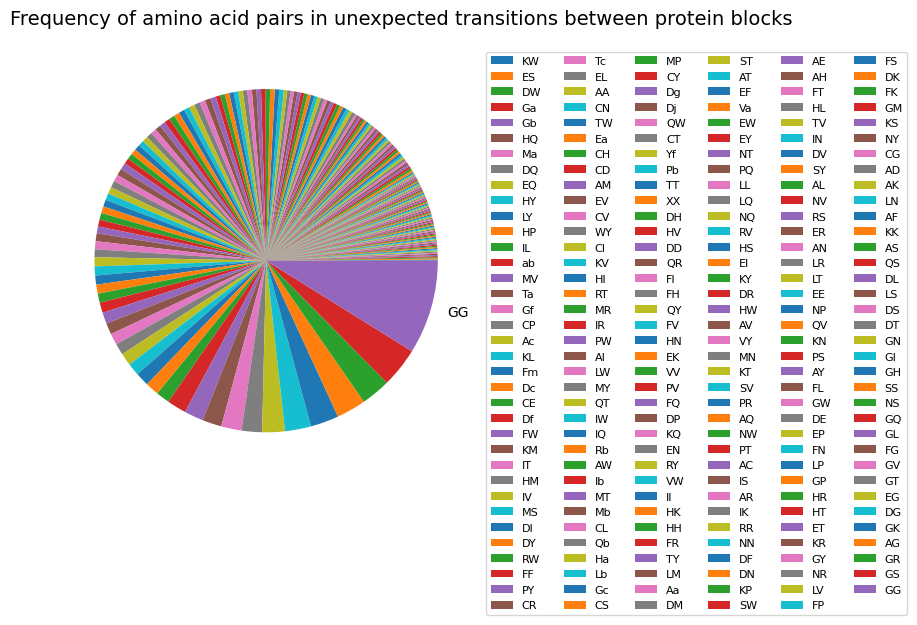

In [8]:
visualize_frequency(df_aa, 'amino acid')

#### The most frequent amino acid pair in unexpected transitions between protein blocks is GG.

## Determining secondary structures associated with unexpected transitions

In [9]:
df_s2, _ = filter_data_set(df, list(('Protein_number', 'PB1', 'PB2', 'expected_frequency', 'AA1', 'AA2')), 'S2_1-S2_2')
df_s2

,S2_1,S2_2,S2_1-S2_2,S2_1-S2_2-count
0,I,H,HI,1
1,I,I,II,1
2,B,H,BH,1
3,B,B,BB,1
4,I,S,IS,1
5,B,E,BE,1
6,S,E,ES,2
7,I,C,CI,2
8,G,E,EG,3
9,H,T,HT,5


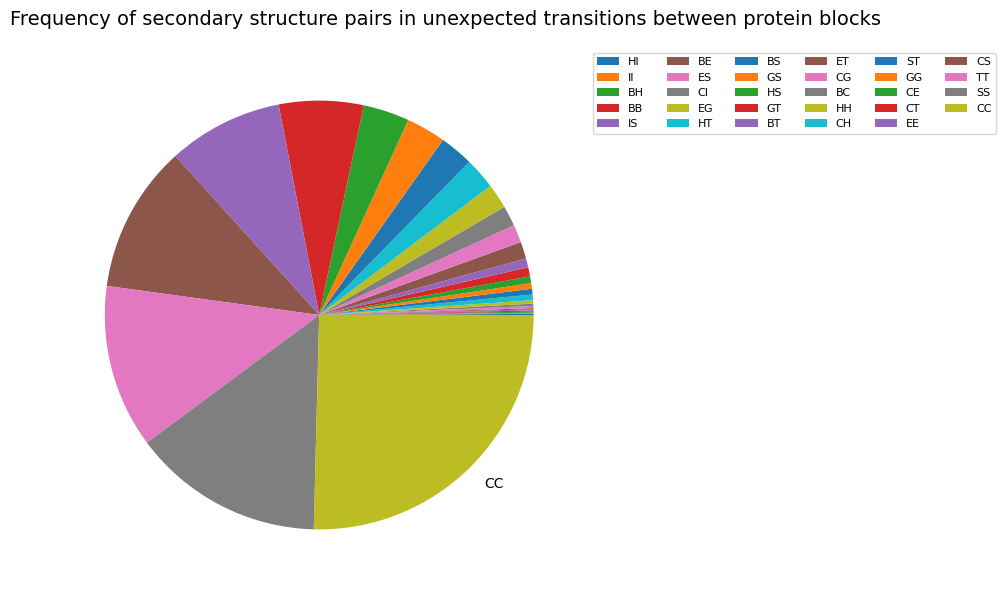

In [10]:
visualize_frequency(df_s2, 'secondary structure')

#### The most frequent secondary structure pair in unexpected transitions between protein blocks is CC.

## Determining which (AA1, AA2) & (S2_1, S2_2) combinations are in the transitions

In [11]:
df_aa_s2, _ = filter_data_set(df, list(('Protein_number', 'PB1', 'PB2', 'expected_frequency')), 'AA1-AA2-S2_1-S2_2')
df_aa_s2

,AA1,AA2,S2_1,S2_2,AA1-AA2-S2_1-S2_2,AA1-AA2-S2_1-S2_2-count
0,K,A,G,G,AGGK,1
1,I,G,S,S,GISS,1
2,K,G,B,C,BCGK,1
3,N,L,T,S,LNST,1
4,P,E,C,T,CEPT,1
...,...,...,...,...,...,...
783,T,D,C,C,CCDT,6
784,G,G,E,C,CEGG,8
785,G,G,S,C,CGGS,9
786,G,G,T,T,GGTT,9


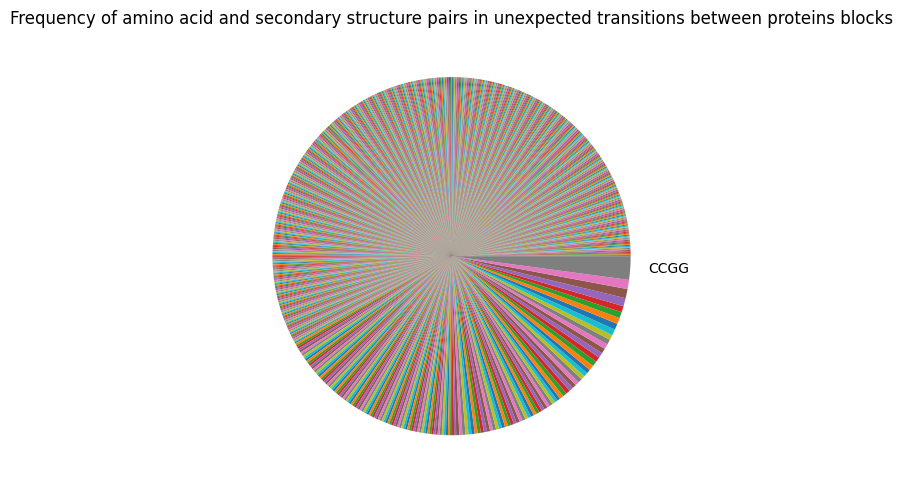

In [12]:
visualize_frequency(df_aa_s2, 'amino acid and secondary structure')

#### The most frequent (AA1, AA2) & (S2_1, S2_2) combination in unexpected transitions between protein blocks is GG CC.